In [123]:
slice='B'

# how many cells of the same type to merge together
merge_count = 2b

base_dir = f'/Users/dd/work/svc/data/secedo_{merge_count}x_{slice}_5_05'

clusters = open(f'{base_dir}/spectral_clustering').readlines()[0][:-1].split(',')
chisel_clustering_lines = open(f'{base_dir}/../mapping{slice}.tsv').readlines()

# will contain <cell_id, gt_cluster, cluster>, where gt_cluster is Chisel's clustering
result = open(f'{base_dir}/../cell_id_gt_spectral', 'w')

# the barcode_to_idx file is created by Secedo during pileup construction (it's in pileups/chromosome_{x}.map)
# it associates each cell id (barcode) with a zero-based index. This index can be used to associate the Secedo
# clustering with the actual cell id/barcode.
cell_id_to_idx_lines = open(f'{base_dir}/../barcode_to_idx_{slice}.map').readlines()

print(
    f'{len(clusters)} clustered cells, {len(cell_id_to_idx_lines)} barcode->id mappings, {len(chisel_clustering_lines)} ground truth (Chisel) entries')

cell_id_to_idx = {}
cell_idx_to_id = {}
for line in cell_id_to_idx_lines:
    cell_id, cell_idx = line.split('\t')
    cell_idx = int(cell_idx[:-1])
    cell_id_to_idx[cell_id] = cell_idx
    cell_idx_to_id[cell_idx] = cell_id

cell_id_to_clone_idx = {}
for gt_line in chisel_clustering_lines:
    gt_line = gt_line.split('\t')
    # cell id is of form A-AAATGCCCATCTGTAG in mapping_ABCDE, but only AAATGCCCATCTGTAG in mappingB/C/D/E
    cell_id_str = gt_line[0]
    if len(slice) == 1: # single slice
        cell_id_str = slice + '-' + cell_id_str
    clone_idx = gt_line[2][:-1]
    cell_id_to_clone_idx[cell_id_str] = clone_idx
print(cell_id_to_clone_idx)

# Assuming a maximum of 3 clusters detected in one Secedo step
# The maps below count how many times a cell in a Chisel clone has been assigned by to clusters a/b or c by Secedo
# Ideally, all cells in a Chisel clone are assigned to the same cluster by Secedo
id_to_cluster_a = {}
id_to_cluster_b = {}
id_to_cluster_c = {}

other_clusters=0
for i in range(0, len(clusters)):
    cell_id_str = cell_idx_to_id[i]
    if cell_id_str not in cell_id_to_clone_idx:
        print(f'Could not find clone assignment for cell {cell_id_str}')
    clone_idx = cell_id_to_clone_idx[cell_id_str]

    result.write(cell_id_str + '\t' + clone_idx + '\t' + clusters[i] + '\n')

    if int(clusters[i]) == 0:
        if clone_idx not in id_to_cluster_a:
            id_to_cluster_a[clone_idx] = 1
        else:
            id_to_cluster_a[clone_idx] += 1
    elif int(clusters[i]) == 1:
        if clone_idx not in id_to_cluster_b:
            id_to_cluster_b[clone_idx] = 1
        else:
            id_to_cluster_b[clone_idx] += 1
    elif int(clusters[i]) == 2:
        if clone_idx not in id_to_cluster_c:
            id_to_cluster_c[clone_idx] = 1
        else:
            id_to_cluster_c[clone_idx] += 1
    else:
        other_clusters+=1

print("Other clusters: ", other_clusters)

for id, count_a in id_to_cluster_a.items():
    count_b = 0
    count_c = 0
    if id in id_to_cluster_b:
        count_b = id_to_cluster_b[id]
        del id_to_cluster_b[id]
    if id in id_to_cluster_c:
        count_c = id_to_cluster_c[id]
        del id_to_cluster_c[id]
    if count_c > 0:
        print(f'{id}: {count_a}/{count_b}/{count_c}')
    else:
        print(f'{id}: {count_a}/{count_b}')

print('==============')

for id, count_b in id_to_cluster_b.items():
    print(f'{id}: 0/{count_b}')

print('==============')

for id, count_c in id_to_cluster_c.items():
    print(f'{id}: 0/{count_c}')

2224 clustered cells, 2224 barcode->id mappings, 2239 ground truth (Chisel) entries
{'B-AAACCTGAGTAATCCC': 'Clone159', 'B-AAACCTGCATGCCATA': 'Clone19', 'B-AAACCTGTCGTAACCA': 'None', 'B-AAACCTGTCTGGCCTT': 'Clone159', 'B-AAACGGGAGGCATTTC': 'None', 'B-AAACGGGGTTCCCACT': 'Clone118', 'B-AAACGGGTCCACTCGT': 'Clone19', 'B-AAAGATGAGGTGTGCA': 'Clone226', 'B-AAAGATGGTGACCCAC': 'Clone118', 'B-AAAGATGTCTCGAGCG': 'Clone19', 'B-AAAGATGTCTTGCGGG': 'None', 'B-AAAGCAACAAAGCGCA': 'Clone159', 'B-AAAGCAACACGTGCGT': 'Clone19', 'B-AAAGCAACAGACAGTG': 'Clone118', 'B-AAAGCAAGTCTCGGCA': 'None', 'B-AAAGCAATCATGACCA': 'Clone19', 'B-AAAGTAGAGAGGTAGA': 'Clone19', 'B-AAAGTAGCATATCGCA': 'Clone159', 'B-AAAGTAGTCCGAGTCG': 'Clone159', 'B-AAAGTAGTCGTAGCGC': 'None', 'B-AAATGCCCAACCGCTG': 'None', 'B-AAATGCCCAACGCCGT': 'Clone159', 'B-AAATGCCCAGGTCCCA': 'Clone118', 'B-AAATGCCGTCAACATC': 'Clone159', 'B-AAATGCCGTTACGCCG': 'Clone159', 'B-AAATGCCTCAAAGTGA': 'Clone19', 'B-AAATGCCTCCGTATTT': 'None', 'B-AACACGTAGAAGGTGA': 'Clone19',

In [113]:
# Generate a mapping that groups multiple cells together based on the "ground truth" provided by Chisel (CNV-based
# clustering)

cell_id_to_group = {}
clone_idx_to_count = {}
group_count = 0


for cell_id, clone_idx in cell_id_to_clone_idx.items():
    if cell_id not in cell_id_to_idx:
        continue

    if clone_idx not in clone_idx_to_count:
        clone_idx_to_count[clone_idx] = []

    clone_idx_to_count[clone_idx].append(cell_id)


    if len(clone_idx_to_count[clone_idx]) == merge_count:
        for cell_id in clone_idx_to_count[clone_idx]:
            cell_id_to_group[cell_id] = group_count
        group_count += 1

        del clone_idx_to_count[clone_idx]


print(f'Creating {group_count} complete groups and {len(clone_idx_to_count)} incomplete groups')

print('Incomplete groups: ', clone_idx_to_count.values())

# add incomplete groups
for cells in clone_idx_to_count.values():
    for cell_id in cells:
        cell_id_to_group[cell_id] = group_count
    group_count += 1



print(f'Group count is {group_count}')

group_fname = f'/Users/dd/work/svc/data/breast_group_{slice}_{merge_count}'

group_file = open(group_fname, 'w')
if group_count > 0:
    for i in range(0, len(cell_id_to_group.keys()) - 1):
        group_file.write(str(cell_id_to_group[cell_idx_to_id[i]]) + ',')
    group_file.write(str(cell_id_to_group[cell_idx_to_id[len(cell_id_to_group.keys()) - 1]]))

group_file.close()
print(f'Written grouping to: {group_fname}')


Creating 1110 complete groups and 4 incomplete groups
Incomplete groups:  dict_values([['B-TGGGCGTTCAGAGTAA'], ['B-TTTGGTTAGCAAAGTT'], ['B-TTTGGTTTCGTAAGGG'], ['B-TTTGTCACACCGAACC']])
Group count is 1114
Written grouping to: /Users/dd/work/svc/data/breast_group_B_2


In [114]:
# Compute ARI score of Secedo's clustering relative to the Chisel clustering
from sklearn.metrics import adjusted_rand_score as ari

# Parse the SBM Clone output (run via 'python ~/work/sbmclone/sbmclone.py sbm_input'), assign the clusters
# to cells and compare to the Chisel ground truth clustering (via the ARI score)

print('Mapping back Secedo output to cell ids and comparing with Chisel ground truth')
print(f'Secedo clustered {len(clusters)} cell groups')
print(f'Expanding group clustering to {len(cell_id_to_idx)} cells...')

secedo_cell_clusters = [None] * len(cell_id_to_idx)
print(cell_id_to_group)
for cell_id, cell_idx in cell_id_to_idx.items():
    secedo_cell_clusters[cell_idx] = clusters[cell_id_to_group[cell_idx_to_id[cell_idx]]]

open(f'/Users/dd/work/svc/data/output/cluster-assignments-per-cell_9x.txt', 'w').write(','.join(secedo_cell_clusters))

print('Evaluating SBMClone performance...')
chisel_clusters = []
for i, cluster in enumerate(secedo_cell_clusters):
    cell_id = cell_idx_to_id[i]
    chisel_clusters.append(cell_id_to_clone_idx[cell_id])
print(f'ARI Score {ari(secedo_cell_clusters, chisel_clusters)}')

Mapping back Secedo output to cell ids and comparing with Chisel ground truth
Secedo clustered 2224 cell groups
Expanding group clustering to 2224 cells...
{'B-AAACCTGAGTAATCCC': 0, 'B-AAACCTGTCTGGCCTT': 0, 'B-AAACCTGTCGTAACCA': 1, 'B-AAACGGGAGGCATTTC': 1, 'B-AAACCTGCATGCCATA': 2, 'B-AAACGGGTCCACTCGT': 2, 'B-AAACGGGGTTCCCACT': 3, 'B-AAAGATGGTGACCCAC': 3, 'B-AAAGATGTCTCGAGCG': 4, 'B-AAAGCAACACGTGCGT': 4, 'B-AAAGATGTCTTGCGGG': 5, 'B-AAAGCAAGTCTCGGCA': 5, 'B-AAAGCAATCATGACCA': 6, 'B-AAAGTAGAGAGGTAGA': 6, 'B-AAAGCAACAAAGCGCA': 7, 'B-AAAGTAGCATATCGCA': 7, 'B-AAAGTAGTCGTAGCGC': 8, 'B-AAATGCCCAACCGCTG': 8, 'B-AAAGTAGTCCGAGTCG': 9, 'B-AAATGCCCAACGCCGT': 9, 'B-AAAGCAACAGACAGTG': 10, 'B-AAATGCCCAGGTCCCA': 10, 'B-AAATGCCGTCAACATC': 11, 'B-AAATGCCGTTACGCCG': 11, 'B-AAATGCCTCAAAGTGA': 12, 'B-AACACGTAGAAGGTGA': 12, 'B-AAAGATGAGGTGTGCA': 13, 'B-AACCATGCATAGGGCA': 13, 'B-AACACGTCAGAAGACC': 14, 'B-AACCATGCATGTATGC': 14, 'B-AAATGCCTCCGTATTT': 15, 'B-AACCATGGTGACCCGT': 15, 'B-AACCATGTCTAAGGAA': 16, 'B-AA

(1114, 7)


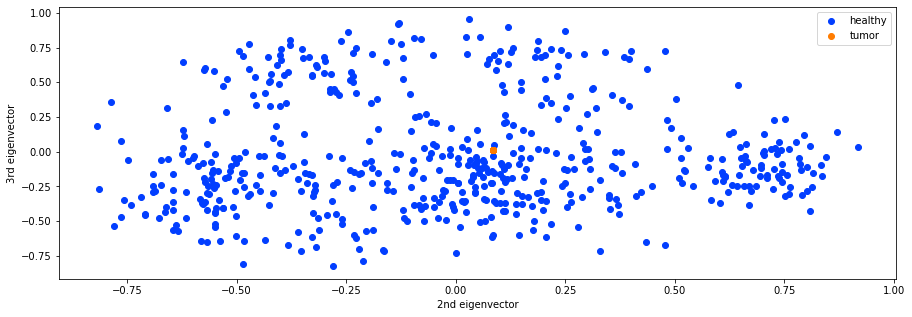

In [121]:
# Plot eigenvectors for the Varsim simulated dataset

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

base_dir = f'/Users/dd/work/svc/data/secedo_{merge_count}x_{slice}_5_05'
data = np.loadtxt(f'{base_dir}/sim_mat_eigenvectors_norm.csv')
colors = sns.color_palette('bright')

x1 = data[:1000,1]
y1 = data[:1000,2]

x2 = data[1000:,1]
y2 = data[1000:,2]



print(data.shape)
fig, axs = plt.subplots(1, 1, figsize=(15,5))

axs.scatter(x1,y1, label='healthy', color = colors[0])
axs.scatter(x2,y2, label='tumor', color = colors[1])



axs.set(xlabel='2nd eigenvector', ylabel='3rd eigenvector')

#fig, axs = plt.subplots(1)
axs.legend(loc='upper right')

In [78]:
# Write out the BAM files that make up each cluster

slice='B'

base_dir = f'/Users/dd/work/svc/data/silver_{slice}_5_05'
clusters = open(f'{base_dir}/clustering').readlines()[0][:-1].split(',')
clusters = [int(c) for c in clusters]

cell_id_to_idx_lines = open(f'{base_dir}/../cell_id_to_idx_{slice}.map').readlines()


cluster_count = int(max(clusters)) + 1

print(f'Found {cluster_count} clusters in clustering of size {len(clusters)}')
print(f'Found {len(cell_id_to_idx_lines)} cells')

print('Creating a list of BAM files for each cluster...')


files = [i for i in range(0, cluster_count)]
files = [open(base_dir+'/cluster_' + str(i) + '.file_list', 'w') for i in range(0,cluster_count)]

for i in range(0, len(clusters)):
    fname = cell_id_to_idx_lines[i].split('\t')[0] + '-1.bam'
    files[clusters[i]].write(fname + '\n')
    
for f in files:
    f.close()

print('Done!')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/dd/work/svc/data/silver_B_5_05/../cell_id_to_idx_B.map'

In [ ]:
# Add ploidy information (from Chisel) to each cell to see if it helps the clustering (it doesn't).

import matplotlib.pyplot as plt
import numpy as np

cov = 1  # 1 means simple (0.03x), 2 means double (0.06x), etc.

base_dir = f'/Users/dd/work/svc/data/secedo_1x_{slice}_5_05'


fploidy = open(f'{base_dir}/../ploidy_all').readlines()
ploidy_map = {}
for p in fploidy:
    cell_id, ploidy = p[:-1].split(',')
    cell_id = cell_id.split('-')[0]
    ploidy_map[cell_id] = float(ploidy)

eigenvectors = np.loadtxt(f'{base_dir}/sim_mat_eigenvectors_norm.csv')

#id_to_group = open(f'{base_dir}/../breast_group_{cov}').readlines()[0].split(',')

# different from clustering_info above: it only contains the cells that were actually processed, together
# with the gt clustering *and* our clustering
clustering_info = open(f'{base_dir}/../cell_id_gt_spectral').readlines()

print(f'Gt lines {len(clustering_info)}')

# for each type of cell (e.g. Clone159, Clone19), contains the (x,y) coordinates given by the 2nd and 3rd eigenvectors
# this allows us to visualize if the clusters are separable in 2D
cell_name_to_xy = {}

x = eigenvectors[:, 1]
y = eigenvectors[:, 2]
num_cells = x.shape[0]

x1 = []
y1 = []
x2 = []
y2 = []
p1 = []
p2 = []

print('Eigenvectors size: ', x.shape[0], '. Cells to process: ', len(clustering_info))

j = 0
for i in range(0, len(clustering_info)):
    gt_str = clustering_info[i].split('\t')
    cell_barcode = gt_str[0]
    cluster_name = gt_str[1]
    cluster = int(gt_str[2])

    if cluster == 16383:  # cell doesn't belong to current subcluster
        continue

    idx = i # int(id_to_group[i])

    if idx >= num_cells:  # shouldn't happen?
        j += 1
        continue

    if cluster_name not in cell_name_to_xy:
        cell_name_to_xy[cluster_name] = ([x[idx]], [y[idx]], [ploidy_map[cell_barcode]])
    else:
        cell_name_to_xy[cluster_name][0].append(x[idx])
        cell_name_to_xy[cluster_name][1].append(y[idx])
        cell_name_to_xy[cluster_name][2].append(ploidy_map[cell_barcode])

    if cluster == 0:
        x1.append(x[idx])
        y1.append(y[idx])
        p1.append(ploidy_map[cell_barcode])
    else:
        x2.append(x[idx])
        y2.append(y[idx])
        p2.append(ploidy_map[cell_barcode])

print('Skipped ', j, ' records.')

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].scatter(x1, y1, label='tumor', color='red')
axs[0].scatter(x2, y2, label='healthy', color='blue')
axs[0].set(xlabel='2nd eigenvector', ylabel='3rd eigenvector')

# fig, axs = plt.subplots(1)

axs[1].scatter(x2, y2, label='healthy', color='blue')
axs[1].scatter(x1, y1, label='tumor', color='red')
axs[1].set(xlabel='2nd eigenvector', ylabel='3rd eigenvector')

fig, axs = plt.subplots(1,  figsize=(15,5))

for k, (v1, v2, v3) in cell_name_to_xy.items():
    if k=='None':
        axs.scatter(v1, v2, label=k, alpha=0.1)
    else:
        axs.scatter(v1, v2, label=k)

# This plots the "None" cells at the end
# (v1,v2) = cell_name_to_xy['None']
# axs.scatter(v1, v2, label='None')

axs.set(xlabel='2nd eigenvector', ylabel='3rd eigenvector')
plt.gca().axes.get_xaxis().set_visible(False)
plt.gca().axes.get_yaxis().set_visible(False)
axs.legend()